# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

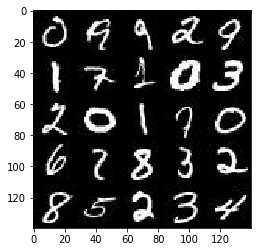

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

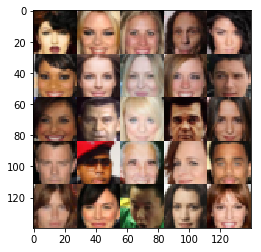

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [30]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

In [41]:
def discriminator(images, reuse=False, keep_prob=0.9):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding="same", 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = leaky_relu(x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding="same", 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        #7x7x64
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding="same", 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
        #4x4X128
        
        #Flatten it
        relu_shape = int(relu3.shape[1]*relu3.shape[2]*relu3.shape[3])
        flat = tf.reshape(relu3, (-1, relu_shape))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [57]:
def generator(z, out_channel_dim, is_train=True, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        #Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = leaky_relu(bn1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding="valid")
        #x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = leaky_relu(bn2)
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = leaky_relu(bn3)
        #print(x3.shape)
        
        x4 = tf.layers.conv2d_transpose(relu3, 64, 5, strides=2, padding="same")
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = leaky_relu(bn4)
        #print(x4.shape)
        
        # Output layer, 28x28x?
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=1, padding="same")
        #print(logits.shape)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [43]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [65]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [61]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2
                
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.1954... Generator Loss: 0.1074
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 6.7575
Epoch 1/2... Discriminator Loss: 0.7197... Generator Loss: 1.6042
Epoch 1/2... Discriminator Loss: 0.4566... Generator Loss: 3.3254
Epoch 1/2... Discriminator Loss: 0.6828... Generator Loss: 3.8005
Epoch 1/2... Discriminator Loss: 0.8805... Generator Loss: 1.3687
Epoch 1/2... Discriminator Loss: 0.6106... Generator Loss: 2.4495
Epoch 1/2... Discriminator Loss: 0.5333... Generator Loss: 3.0843
Epoch 1/2... Discriminator Loss: 0.4237... Generator Loss: 3.3997
Epoch 1/2... Discriminator Loss: 0.5502... Generator Loss: 4.8828


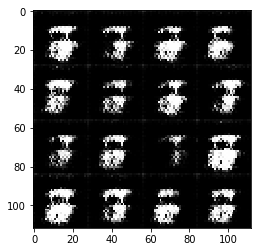

Epoch 1/2... Discriminator Loss: 0.5604... Generator Loss: 2.2680
Epoch 1/2... Discriminator Loss: 0.7167... Generator Loss: 2.1951
Epoch 1/2... Discriminator Loss: 1.0349... Generator Loss: 1.2058
Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 2.9958
Epoch 1/2... Discriminator Loss: 0.9581... Generator Loss: 3.0002
Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 1.5288
Epoch 1/2... Discriminator Loss: 0.8891... Generator Loss: 2.0943
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 1.7289
Epoch 1/2... Discriminator Loss: 0.8057... Generator Loss: 1.8495
Epoch 1/2... Discriminator Loss: 0.6323... Generator Loss: 2.8789


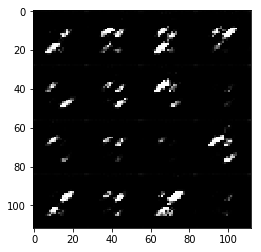

Epoch 1/2... Discriminator Loss: 0.6117... Generator Loss: 1.8310
Epoch 1/2... Discriminator Loss: 0.7581... Generator Loss: 2.4194
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 4.6638
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 3.0537
Epoch 1/2... Discriminator Loss: 0.6562... Generator Loss: 2.1216
Epoch 1/2... Discriminator Loss: 0.4702... Generator Loss: 4.8510
Epoch 1/2... Discriminator Loss: 0.4711... Generator Loss: 3.6867
Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 1.4208
Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 3.6728
Epoch 1/2... Discriminator Loss: 0.7748... Generator Loss: 1.8243


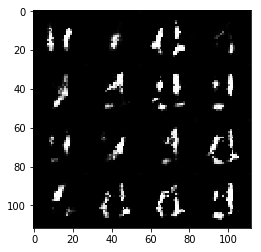

Epoch 1/2... Discriminator Loss: 0.7430... Generator Loss: 1.7776
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 1.9948
Epoch 1/2... Discriminator Loss: 0.6542... Generator Loss: 1.7873
Epoch 1/2... Discriminator Loss: 0.9170... Generator Loss: 1.6458
Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 2.6016
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 2.3855
Epoch 1/2... Discriminator Loss: 2.0533... Generator Loss: 4.2794
Epoch 1/2... Discriminator Loss: 0.5926... Generator Loss: 2.1392
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 1.7078
Epoch 1/2... Discriminator Loss: 0.5807... Generator Loss: 2.2363


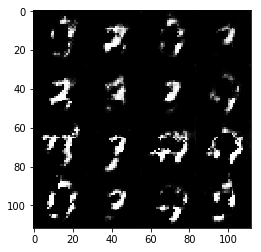

Epoch 1/2... Discriminator Loss: 0.7734... Generator Loss: 1.5790
Epoch 1/2... Discriminator Loss: 0.7926... Generator Loss: 1.4830
Epoch 1/2... Discriminator Loss: 0.7872... Generator Loss: 1.6065
Epoch 1/2... Discriminator Loss: 0.7027... Generator Loss: 2.3360
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 1.4303
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.2221
Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 1.5582
Epoch 1/2... Discriminator Loss: 0.8392... Generator Loss: 1.4211
Epoch 1/2... Discriminator Loss: 0.8476... Generator Loss: 1.6613
Epoch 1/2... Discriminator Loss: 0.8240... Generator Loss: 1.4518


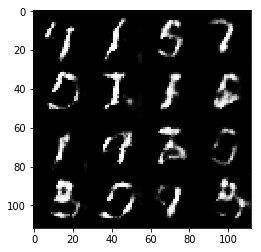

Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 0.8022... Generator Loss: 2.0578
Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 1.3273
Epoch 1/2... Discriminator Loss: 1.0019... Generator Loss: 1.1972
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 1.2401
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 1.6788
Epoch 1/2... Discriminator Loss: 1.0841... Generator Loss: 2.6550
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.9511
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 1.0262
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 1.3194


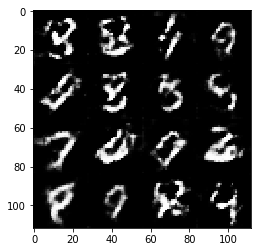

Epoch 1/2... Discriminator Loss: 0.9165... Generator Loss: 1.7810
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 1.0822
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 1.5133
Epoch 1/2... Discriminator Loss: 0.8735... Generator Loss: 1.2946
Epoch 1/2... Discriminator Loss: 0.9539... Generator Loss: 1.3170
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 1.0983
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 1.9082
Epoch 1/2... Discriminator Loss: 1.1152... Generator Loss: 0.9143
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 1.4568
Epoch 1/2... Discriminator Loss: 1.0013... Generator Loss: 1.1166


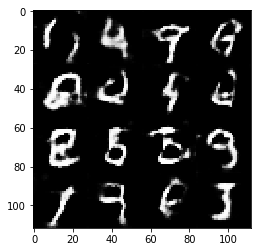

Epoch 1/2... Discriminator Loss: 0.8681... Generator Loss: 1.3293
Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 0.9683
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.6729
Epoch 1/2... Discriminator Loss: 0.9608... Generator Loss: 1.3301
Epoch 1/2... Discriminator Loss: 1.0727... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 1.1059
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 1.0390
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 0.9514
Epoch 1/2... Discriminator Loss: 1.0197... Generator Loss: 1.3345


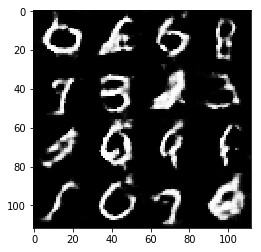

Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 1.2907
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 1.2904
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 1.8724
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 1.1438
Epoch 1/2... Discriminator Loss: 1.1963... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 0.6679
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 1.2385
Epoch 1/2... Discriminator Loss: 1.0797... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 0.9790
Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 1.1617


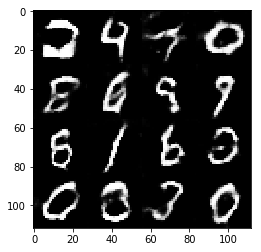

Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.8947
Epoch 1/2... Discriminator Loss: 0.9573... Generator Loss: 1.5081
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 1.0838
Epoch 2/2... Discriminator Loss: 1.1481... Generator Loss: 1.2257
Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 1.3675
Epoch 2/2... Discriminator Loss: 1.0368... Generator Loss: 1.5679
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 1.8619
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.5977
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 1.0865


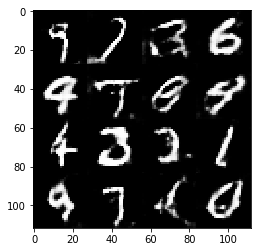

Epoch 2/2... Discriminator Loss: 1.1488... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 1.0073... Generator Loss: 1.5953
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 0.9238
Epoch 2/2... Discriminator Loss: 1.3121... Generator Loss: 1.7090
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 0.8952
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 0.6941
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 1.0737
Epoch 2/2... Discriminator Loss: 1.2422... Generator Loss: 0.6492


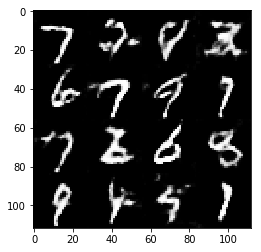

Epoch 2/2... Discriminator Loss: 1.0042... Generator Loss: 1.2635
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 1.2784
Epoch 2/2... Discriminator Loss: 1.1911... Generator Loss: 1.0832
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 1.1771
Epoch 2/2... Discriminator Loss: 2.0658... Generator Loss: 0.2654
Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 1.5086
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 1.2769... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.2326... Generator Loss: 0.9621


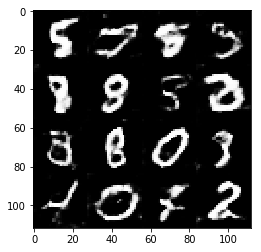

Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 1.0485
Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 1.1073
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 1.1593
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 1.1309
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 1.2390
Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 0.9736
Epoch 2/2... Discriminator Loss: 1.1823... Generator Loss: 0.9025


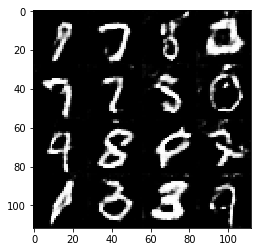

Epoch 2/2... Discriminator Loss: 1.0214... Generator Loss: 1.0722
Epoch 2/2... Discriminator Loss: 1.2077... Generator Loss: 0.7415
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 1.1806
Epoch 2/2... Discriminator Loss: 1.1070... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 1.1666... Generator Loss: 1.1484
Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 0.8771
Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 0.5141
Epoch 2/2... Discriminator Loss: 1.0041... Generator Loss: 1.3144
Epoch 2/2... Discriminator Loss: 1.5030... Generator Loss: 1.8407
Epoch 2/2... Discriminator Loss: 1.0727... Generator Loss: 1.4301


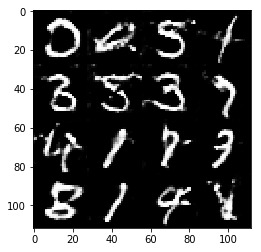

Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 0.9270
Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 0.8942
Epoch 2/2... Discriminator Loss: 1.1416... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 1.9684
Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 1.3443
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 1.1241
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 2.3586
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 1.0334


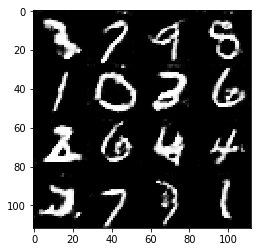

Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 1.0324
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 0.8837
Epoch 2/2... Discriminator Loss: 1.0459... Generator Loss: 1.0521
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 1.3752
Epoch 2/2... Discriminator Loss: 1.4327... Generator Loss: 0.4747
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.8927
Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 1.2319
Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 0.9659
Epoch 2/2... Discriminator Loss: 1.0860... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 1.4868


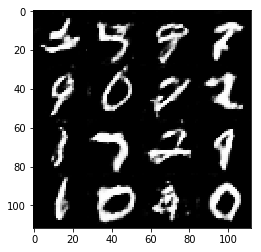

Epoch 2/2... Discriminator Loss: 1.6281... Generator Loss: 0.4107
Epoch 2/2... Discriminator Loss: 1.1705... Generator Loss: 1.1897
Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 1.6041
Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 2.4683
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 1.5136
Epoch 2/2... Discriminator Loss: 1.1431... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 1.1002
Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 1.4375
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 1.2694
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 0.9306


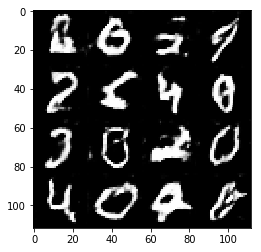

Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 1.0784
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 1.2649
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 1.5276
Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 1.5656
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 1.7056
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.8435
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 1.4394
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 1.0276
Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 0.9248


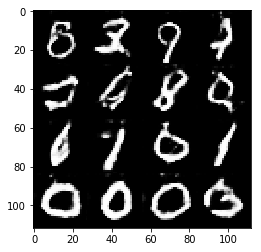

Epoch 2/2... Discriminator Loss: 1.1906... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 1.9947
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.5114
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 0.9128
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 1.2432
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 1.0346
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 1.4108


In [58]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.2886... Generator Loss: 0.1277
Epoch 1/1... Discriminator Loss: 1.9585... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.6323... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.5621
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 1.5947
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.7336
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.4701


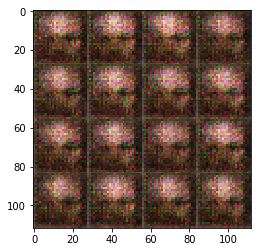

Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 1.5206
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.9806
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 2.4867
Epoch 1/1... Discriminator Loss: 0.6565... Generator Loss: 1.9786
Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 2.3680
Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 2.1557
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 2.4649
Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 2.7617
Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 2.6930
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 2.3225


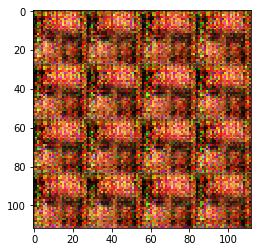

Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 2.1693
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 2.2878
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 2.7368
Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 2.8251
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 2.6048
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 3.3267
Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 3.1568
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 2.4334
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 2.9577


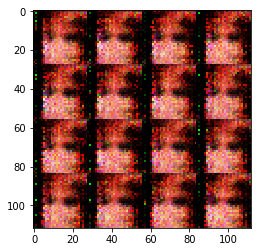

Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 3.2477
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 2.6919
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 2.6954
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 3.1923
Epoch 1/1... Discriminator Loss: 0.4805... Generator Loss: 3.5344
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 1.9085
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 2.5448
Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 2.9152
Epoch 1/1... Discriminator Loss: 0.4700... Generator Loss: 2.9244
Epoch 1/1... Discriminator Loss: 0.4574... Generator Loss: 2.9890


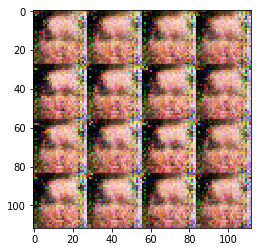

Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 3.3384
Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 1.8362
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 2.6027
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 1.1737
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 2.2958
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 1.2739
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.2254


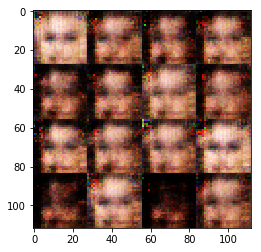

Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.4778
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.7250
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.4134
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 1.4921


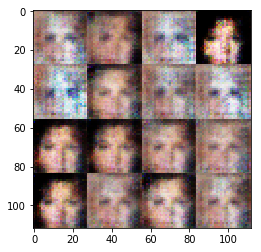

Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.4411
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.3172
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 1.4655
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 1.3101
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.2860
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.2899


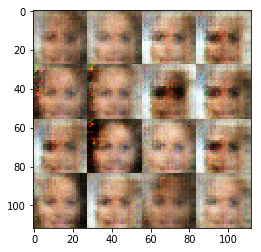

Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.6092
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.2824
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.3434
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.3681
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.8314


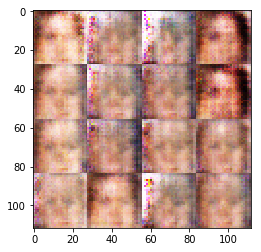

Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 0.8483... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 1.8747... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 1.3903
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.9812


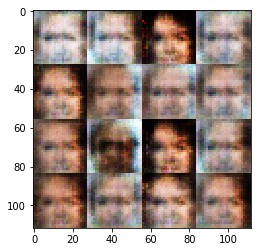

Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.3496
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 1.6630... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.2816


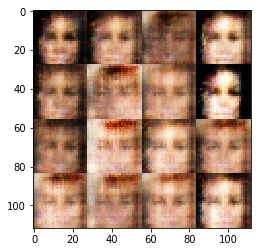

Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.3643
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.4840


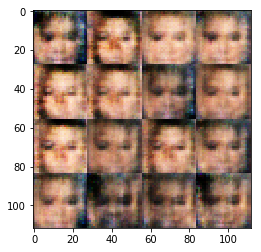

Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.3827
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.2806
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.6049


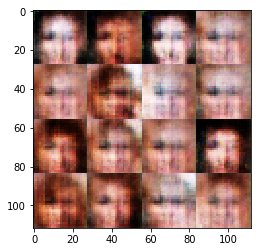

Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 1.3678
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 1.3505
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.3671
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.9611


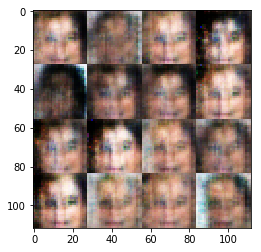

Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.2299
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.5787
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.3634
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.3146


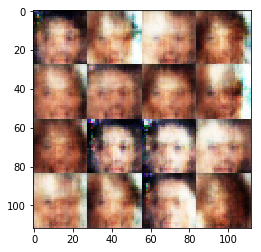

Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.1555


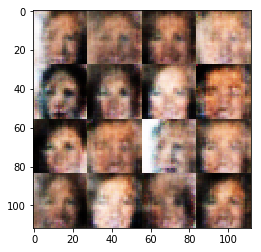

Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 1.1799
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.9981


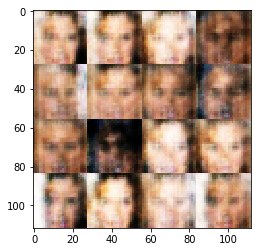

Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 1.1285


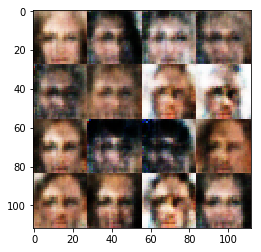

Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 1.0840


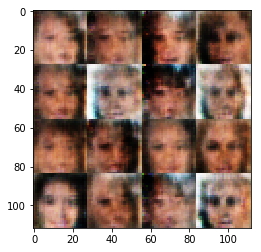

Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 1.1210
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.2173


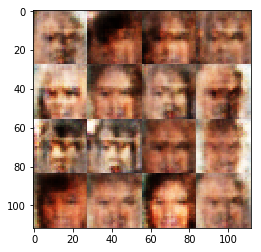

Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.3166
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.0089


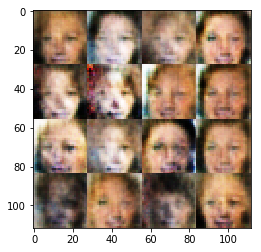

Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.9073


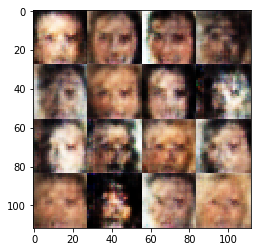

Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.0474


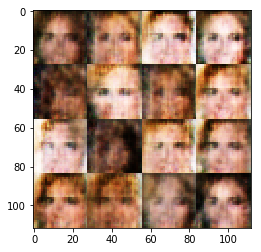

Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.9732


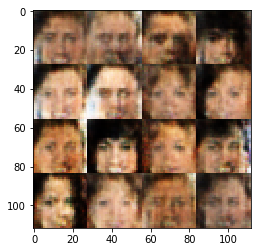

Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.9222


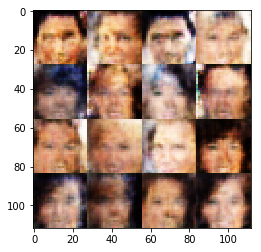

Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.3173
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.9929


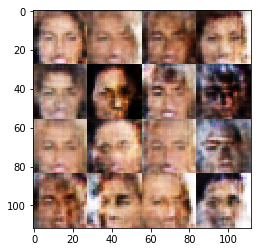

Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8664


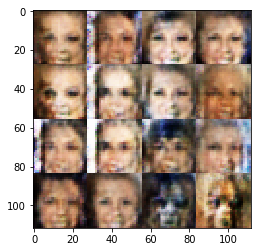

Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9762


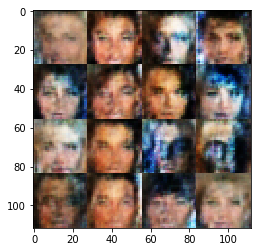

Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.9825


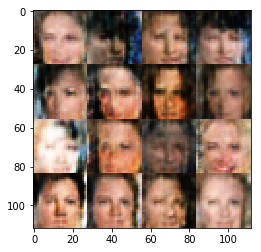

Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 1.0270


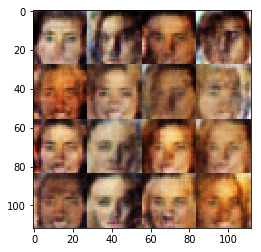

Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.9212


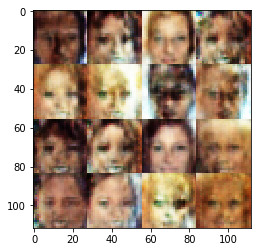

Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7441


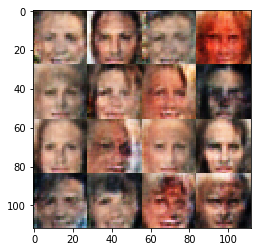

Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.9420


In [66]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.